In [ ]:
# Run this if you don't have qutip installed
!pip install qutip

In [2]:
import numpy as np
import qutip as qp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List

## Prepare code for quantum channel

In [3]:
PAULIS = [
    np.array([[0, 1], [1, 0]], dtype=complex),
    np.array([[0, 1j], [-1j, 0]], dtype=complex),
    np.array([[1, 0], [0, -1]], dtype=complex),
]

In [4]:
class Channel:
    ops: List[np.ndarray]
        
    def __init__(self, ops: List[np.ndarray]):
        self.ops = ops
        
        
    def __call__(self, rho: np.ndarray):
        assert rho.ndim == 2, "Density matrix should have 2 dimensions"
        
        def apply_K(rho, K: np.ndarray):
            return K @ rho @ K.conj().T
        r = [apply_K(rho, k) for k in self.ops]
        return sum(r)
    
class DephasingChannel(Channel):
    def __init__(self, p: float):
        """
        Arguments:
            p: probability of a phase erorr
        """
        super().__init__([
            np.sqrt(1-p)*np.eye(2),
            np.sqrt(p)*PAULIS[2],
        ])
        
class DepolarizingChannel(Channel):
    def __init__(self, p: float):
        """
        Arguments:
            p: probability of a bit erorr
        """
        super().__init__([
            np.sqrt(1-p)*np.eye(2),
            np.sqrt(p)*PAULIS[0],
        ])
    
class GateChannel(Channel):
    """ Just application of unitary gate to a matrix"""
    def __init__(self, U: np.ndarray):
        super().__init__([U])

In [5]:
def pauli_unitary(a, b, c):
    """
    Returns exp(-i*c*pauli.m)
    where m = (sin(a)cos(b), sin(a)sin(b), cos(b))
    
    Rotation on the Bloch sphere around vector m 
    with angle c
    """
    v = np.array([
        np.sin(a)*np.cos(b),
        np.sin(a)*np.sin(b),
        np.cos(a)
    ])
    paulis = np.array(PAULIS)
    R = np.sum([paulis[i]*v[i] for i in range(3)], axis=0)
    return np.cos(c)*np.eye(2) - 1j*np.sin(c)*R


In [6]:
small_x_rot = pauli_unitary(np.pi/2, 0, .05)
rotation = GateChannel(small_x_rot)
print(small_x_rot)

[[0.99875026-3.06034148e-18j 0.        -4.99791693e-02j]
 [0.        -4.99791693e-02j 0.99875026+3.06034148e-18j]]


In [7]:
def state_to_rho(psi):
    return np.outer(psi, psi)

rho_example = state_to_rho([1, 0])
rho_example

array([[1, 0],
       [0, 0]])

In [8]:
rotation(rho_example)

array([[9.97502083e-01+7.81501225e-35j, 1.52953325e-19+4.99167083e-02j],
       [1.52953325e-19-4.99167083e-02j, 2.49791736e-03+0.00000000e+00j]])

## Visualize the density matrix

In [9]:
def expectation(rho, op):
    return np.trace(rho @ op)

def new_3d_axis():
    f, axs = plt.subplots(1, 1, figsize=(12, 5), subplot_kw={'projection': '3d'})
    return f, axs

def new_bloch_sphere():
    f, ax = plt.gcf(), plt.gca()
    bloch_sphere = qp.Bloch(fig=f, axes=ax)
    bloch_sphere.font_size = 12
    return bloch_sphere

def vis_rho(rho, bloch_sphere=None, vec=True):
    vs = [np.real(expectation(rho, p)) for p in PAULIS]
    if bloch_sphere is None:
        bloch_sphere = new_bloch_sphere()
    if vec:
        bloch_sphere.add_vectors(vs)
    else:
        bloch_sphere.add_points(vs)
    return bloch_sphere


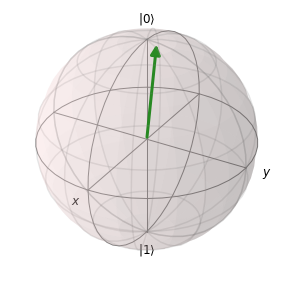

In [10]:
new_3d_axis()
sph = vis_rho(rotation(rho_example), vec=True)
sph.render()

### Visualise evolution of a qubit

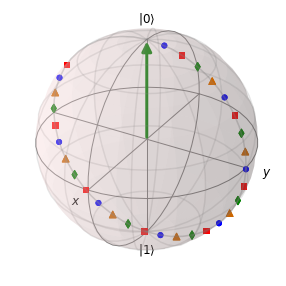

In [11]:
N = 30
dphi = (np.pi-0.5)/N
small_x_rot = pauli_unitary(np.pi/2, 0, dphi)
rotation = GateChannel(small_x_rot)
rho = state_to_rho([1, 0])

new_3d_axis()
sphere = new_bloch_sphere()
vis_rho(rho, sphere)
for i in range(N):
    rho = rotation(rho)
    vis_rho(rho, sphere, vec=False)
sphere.render()

## Implement an error channel

In [12]:
dephasing = DephasingChannel(0.05)
dephasing = DepolarizingChannel(0.02)
print(dephasing.ops)
dephasing(rho_example)

[array([[0.98994949, 0.        ],
       [0.        , 0.98994949]]), array([[0.        +0.j, 0.14142136+0.j],
       [0.14142136+0.j, 0.        +0.j]])]


array([[0.98+0.j, 0.  +0.j],
       [0.  +0.j, 0.02+0.j]])

### Evolution without noise

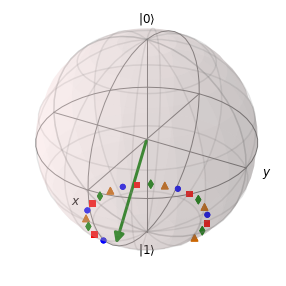

In [149]:
new_3d_axis()
sphere = new_bloch_sphere()
init_state = [np.sin(.3), np.cos(.3)]
rho = state_to_rho(init_state)
vis_rho(rho, sphere)
for i in range(N):
    rho = rotation(rho)
    vis_rho(rho, sphere, vec=False)
sphere.render()

### Dephasing noise

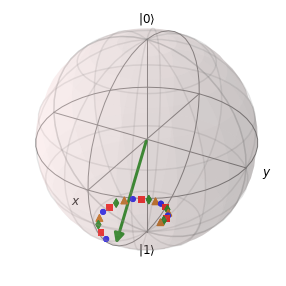

In [150]:
dephasing = DephasingChannel(0.03)

N = 20
dphi = (np.pi-0.7)/N
# Rotation along Z axis
small_x_rot = pauli_unitary(0, 0, dphi)
rotation = GateChannel(small_x_rot)

new_3d_axis()
sphere = new_bloch_sphere()
init_state = [np.sin(.3), np.cos(.3)]

rho = state_to_rho(init_state)
vis_rho(rho, sphere)
for i in range(N):
    rho = rotation(rho)
    rho = dephasing(rho)
    vis_rho(rho, sphere, vec=False)
sphere.render()

### Depolarizing noise

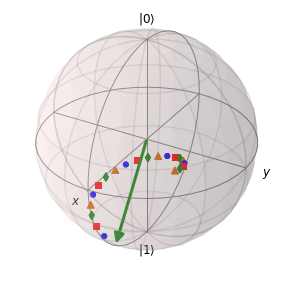

In [152]:
new_3d_axis()
sphere = new_bloch_sphere()
depol = DepolarizingChannel(0.03)
rho = state_to_rho(init_state)
vis_rho(rho, sphere)
for i in range(N):
    rho = rotation(rho)
    rho = depol(rho)
    vis_rho(rho, sphere, vec=False)

sphere.render()

### Convert density matrix result

In [14]:
x = expectation(rho, PAULIS[0])
y = expectation(rho, PAULIS[1])
z = expectation(rho, PAULIS[2])

In [266]:
rhh = 1/2*(np.eye(2) + x*PAULIS[0] + y*PAULIS[1] + z*PAULIS[2])

## Simple error correction

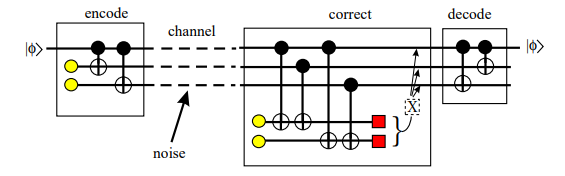

In [43]:
import qiskit
from qiskit import QuantumCircuit, Aer
from qiskit import transpile

<BarContainer object of 4 artists>

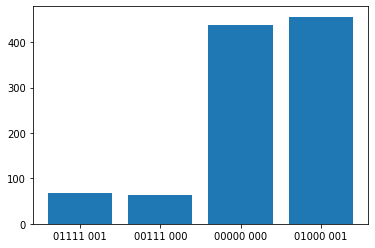

In [79]:
q= qiskit.QuantumRegister(5)
c= qiskit.ClassicalRegister(3)
circ = QuantumCircuit(q, c)

# Prepare the state
circ.rx(0.7, 0)
# Encode 
circ.cx(0, 1)
circ.cx(0, 2)

# Apply noise
circ.h(0)

# Measure syndroms

circ.cx(0, 3)
circ.cx(1, 3)
circ.cx(1, 4)
circ.cx(2, 4)
circ.measure(3, c[0])
circ.measure(4, c[1])
# Correct errors
circ.x(0).c_if(c, 1)
circ.x(1).c_if(c, 3)
circ.x(2).c_if(c, 2)

# decode
circ.cx(1, 0)
circ.cx(2, 0)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plt.bar(x=counts.keys(), height=counts.values())

Explanation of the label:
    
    01111 001
    abcde ABC 

    
1. `ab` -- Error syndromes
2. `cde` -- Qubit encoding
3. `e` -- Original qubit
4. `ABC` -- Classical register
    


## Run multiple experiments

In [144]:
def error_experiment(err_angle):
    q= qiskit.QuantumRegister(5)
    c= qiskit.ClassicalRegister(3)
    circ = QuantumCircuit(q, c)

    # Prepare the state
    circ.rx(0.7, 0)
    # Encode 
    circ.cx(0, 1)
    circ.cx(0, 2)

    # Apply noise
    circ.rx(err_angle, 0)
    # Try introducing an un-correctable error!
    #circ.rx(err_angle, 1)

    # Measure syndroms
    circ.cx(0, 3)
    circ.cx(1, 3)
    circ.cx(1, 4)
    circ.cx(2, 4)
    circ.measure(3, c[0])
    circ.measure(4, c[1])
    
    # Correct errors
    circ.x(0).c_if(c, 1)
    circ.x(1).c_if(c, 3)
    circ.x(2).c_if(c, 2)

    # decode
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.measure_all()

    # Transpile for simulator
    simulator = Aer.get_backend('aer_simulator')
    circ = transpile(circ, simulator)

    # Run and get counts
    result = simulator.run(circ).result()
    counts = result.get_counts(circ)
    return counts

In [139]:
all_counts = {}
for err_angle in [0, 0.5, 0.7, 2, 3]:
    counts = error_experiment(err_angle)
    all_counts.update(**counts)

### Convert the measurement result


In [140]:
res = {}
for key in all_counts:
    res[key[4]] = all_counts[key]

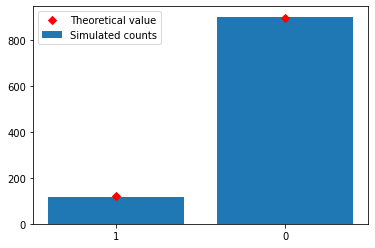

In [142]:
plt.bar(x=res.keys(), height=res.values(), label='Simulated counts')
angle = 0.7
theor = np.square([np.sin(angle/2), np.cos(angle/2)])*sum(res.values())
plt.plot(['1', '0'], theor, 'D', color='red', label='Theoretical value')
plt.legend()

In [143]:
# All results observed
print(all_counts.keys())

dict_keys(['00111 000', '00000 000', '01111 001', '01000 001'])


In [154]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.20.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': None, 'qiskit': '0.36.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.3.2', 'qiskit-machine-learning': None}

---

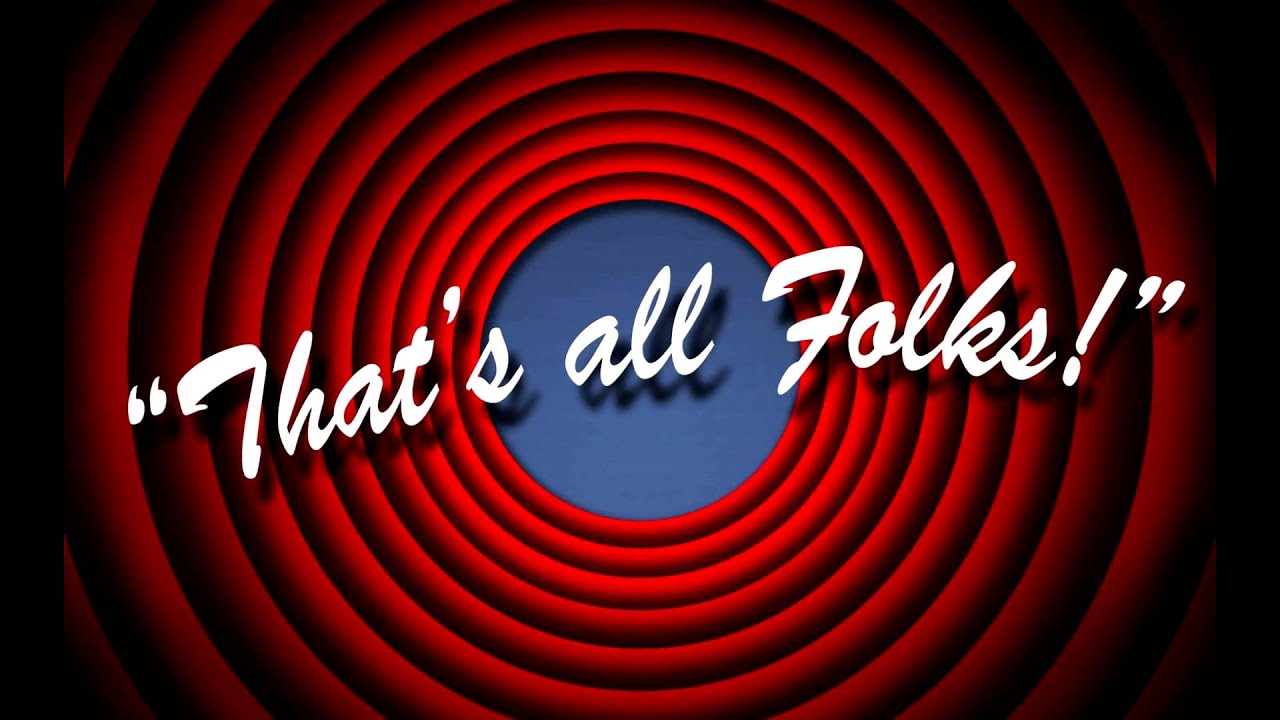